In [1]:
import netCDF4 as nc
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import scipy
import plotly.express as px
from scipy.stats import mstats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import csv
import fiona
import geopandas
pd.set_option('display.max_rows', 24000)

In [2]:
#loading in mortality dataset from hierarchy file (available on Zenodo)
#fn is the full aggregated dataset
fn = "/projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-incadapt.nc4"


#fn1 is the HistClim dataset
fn1 = "/projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/3_impacts/main_specification/raw/single/rcp85/CCSM4/low/SSP3/Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-noadapt.nc4"


In [3]:
#loading in shapefile associated with hierarchy file
shapefile = "/projects/kopp/dtb96/branches/Mortality_Project/data/impact_high_res"
new_shapefile = "/projects/kopp/dtb96/branches/Mortality_Project/data/new_shapefile_nytimes"
sf = geopandas.read_file(new_shapefile)
print(sf)

       gadmid           hierid  color  ISO  \
0       28115       CAN.1.2.28      1  CAN   
1       28116     CAN.1.17.403      2  CAN   
2       28119     CAN.2.34.951      3  CAN   
3       28120  CAN.11.259.4274      4  CAN   
4       28124  CAN.11.269.4448      5  CAN   
...       ...              ...    ...  ...   
24373    6905            BWA.1  24374  BWA   
24374    6902            BWA.7  24375  BWA   
24375    6915         BWA.6.16  24376  BWA   
24376    6909            BWA.5  24377  BWA   
24377    6912         BWA.4.13  24378  BWA   

                                                geometry  
0      POLYGON ((-110.05459 53.30730, -110.00587 53.3...  
1      POLYGON ((-111.23055 52.91943, -111.22076 52.9...  
2      POLYGON ((-127.68527 55.29570, -127.69742 55.3...  
3      POLYGON ((-77.73080 55.31879, -77.71030 55.317...  
4      POLYGON ((-66.25940 54.99975, -65.24999 55.000...  
...                                                  ...  
24373  POLYGON ((26.01723 -23.5586

In [4]:
def fix_region(ds):
    """Clean raw mortality Datasets so region is helpful.

    Changes coords/dims/vars so 'region' is region names we can select data by.
    For e.g. `ds.sel(region='IND.10.121')` should work properly.
    """
    return ds.set_coords("regions").swap_dims({"region": "regions"}).rename({"regions": "region"})


ds = fix_region(xr.open_dataset(fn))
ds1 = fix_region(xr.open_dataset(fn1))
ds

<xarray.Dataset>
Dimensions:            (year: 120, region: 24378, operation: 4)
Coordinates:
  * year               (year) int32 1981 1982 1983 1984 ... 2097 2098 2099 2100
  * region             (region) object 'CAN.1.2.28' ... 'BWA.4.13'
Dimensions without coordinates: operation
Data variables:
    rebased            (year, region) float32 ...
    transformed        (year, region) float32 ...
    response           (year, region) float32 ...
    climtas_effect     (year, region) float32 ...
    orderofoperations  (operation) object ...
Attributes:
    description:   Mortality impacts, with interpolation and only environment...
    version:       Agespec_interaction_GMFD_POLY-4_TINV_CYA_NW_w1-oldest-inca...
    dependencies:  1.6, Hierarchy.2016-02-03, Hierarchy.2016-02-03, GCP-GDPPC...
    author:        James Rising

In [5]:
#test = ds['region'].to_pandas()
#display(test.to_string())

In [6]:
#isolating individual regions to analyze - using this for meshgrid

DEL = ds.sel(region ='IND.10.121.371')    #Delhi - 3 versions listed in hierarchy file
OSL = ds.sel(region ='NOR.12.288')        #Oslo
CHI = ds.sel(region ='USA.24.1332')       #Cook County aka Chicagoland area
SPB = ds.sel(region ='BRA.25.5269.9934')  #Fatima Paulista, had problems with Sao Paulo ID
ACC = ds.sel(region ='GHA.5.70')          #Accra
SYD = ds.sel(region ='AUS.4.242')         #North Sydney 
BEI = ds.sel(region ='CHN.2.18.84')       #Miyun District - had problems with Beijing ID

#isolating the regions again for the difference calculation down the road
DEL1 = ds1.sel(region ='IND.10.121.371')
OSL1 = ds1.sel(region ='NOR.12.288')
CHI1 = ds1.sel(region ='USA.24.1332')        
SPB1 = ds1.sel(region ='BRA.25.5269.9934')  
ACC1 = ds1.sel(region ='GHA.5.70')
SYD1 = ds1.sel(region ='AUS.4.242')    
BEI1 = ds1.sel(region ='CHN.2.18.84')


In [7]:
q = (0.17, 0.5, 0.83)
window_n = 20
rebased_qs = ds["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile(q,skipna= False, dim="tmp")
rebased_qs1 = ds1["rebased"].rolling({"year": window_n}, center=False).construct("tmp").quantile(q,skipna= False, dim="tmp")

In [8]:
# a_1 = np.where(rebased_qs.sel(region="AUS.4.242", quantile=0.17, year 2010) >=rebased_qs.sel(region="AUS.4.242",quantile=0.83, year =2010))
# a_1 = np.asarray(a_1)
# a1 = a_1.min(axis=0)
# amin1 = min(a1)

# TOE_labela1 = amin1 + 1981

# rebased_qs.sel(region="AUS.4.242").plot.line(x="year")
# plt.title("AUS.4.242/CCSM4/low/SSP3/oldest/no-adapt")
# plt.axvline(x = amin1+1981, linestyle='--',c='black' ,label = "TOE - " + str(TOE_labela1) )
# plt.axhline(y=rebased_qs.sel(region="AUS.4.242", quantile=0.17,year=2010), linestyle='--', c='b')
# plt.axhline(y=rebased_qs.sel(region="AUS.4.242", quantile=0.83,year=2010), linestyle='--', c='g')
# plt.legend()

In [9]:
# a_2 = np.where(rebased_qs1.sel(region="AUS.4.242", quantile=0.17) >=rebased_qs1.sel(region="AUS.4.242",quantile=0.83, year =2010))
# a_2 = np.asarray(a_2)
# a2 = a_2.min(axis=0)
# amin2 = min(a2)

# TOE_labela2 = amin2 + 1981

# rebased_qs1.sel(region="AUS.4.242").plot.line(x="year")
# plt.title("AUS.4.242/CCSM4/low/SSP3/oldest/inc-adapt")
# plt.axvline(x = amin2+1981, linestyle='--',c='black' ,label = "TOE - " + str(TOE_labela) )
# plt.axhline(y=rebased_qs1.sel(region="AUS.4.242", quantile=0.83,year=2010), linestyle='--', c='g')
# plt.legend()

In [10]:
#Simple difference between full income-full adaptation and Histclim
diff = ds["rebased"] - ds1["rebased"]

rebased_diff = diff.rolling({"year": window_n}, center=False).construct("tmp").quantile(q,skipna= False, dim="tmp")



In [11]:
#calculating where 83rd or 17th%-tile crosses x-axis

window = slice(2010,2100)

def fun_threshold(quant,yr):
    threshold = rebased_qs.sel(quantile=quant, year=yr)
    return threshold

def fun_threshold_1(quant,yr):
    threshold_1 = rebased_qs1.sel(quantile=quant, year=yr)
    return threshold_1

In [12]:
#damages
mask_years_over_threshold_damages = fun_threshold(0.83, 2010) <= fun_threshold(0.17, window)
earliest_threshold_year_damages = mask_years_over_threshold_damages.idxmax(dim="year")
earliest_threshold_year_damages


mask_years_over_threshold_damages_1 = fun_threshold_1(0.83, 2010) <= fun_threshold_1(0.17, window)
earliest_threshold_year_damages_1 = mask_years_over_threshold_damages_1.idxmax(dim="year")


In [13]:
#benefits
mask_years_over_threshold_benefits = fun_threshold(0.17, 2010) >= fun_threshold(0.83, window)
earliest_threshold_year_benefits = mask_years_over_threshold_benefits.idxmax(dim="year")
earliest_threshold_year_benefits

mask_years_over_threshold_benefits_1 = fun_threshold_1(0.17, 2010) >= fun_threshold_1(0.83, window)
earliest_threshold_year_benefits_1 = mask_years_over_threshold_benefits_1.idxmax(dim="year")


In [14]:
earliest_threshold_year_benefits_1

<xarray.DataArray 'year' (region: 24378)>
array([2050, 2047, 2056, ..., 2048, 2010, 2010], dtype=int32)
Coordinates:
  * region   (region) object 'CAN.1.2.28' 'CAN.1.17.403' ... 'BWA.5' 'BWA.4.13'

In [15]:
sf['TOE_benefits'] = earliest_threshold_year_benefits
sf['TOE_damages'] = earliest_threshold_year_damages
sf['TOE_benefits'] = sf['TOE_benefits'].replace(2010,np.NaN)
sf['TOE_damages'] = sf['TOE_damages'].replace(2010,np.NaN)


sf['TOE_benefits_1'] = earliest_threshold_year_benefits_1
sf['TOE_damages_1'] = earliest_threshold_year_damages_1
sf['TOE_benefits_1'] = sf['TOE_benefits_1'].replace(2010,np.NaN)
sf['TOE_damages_1'] = sf['TOE_damages_1'].replace(2010,np.NaN)


In [16]:
# Function to calculate meshgrid diff between full aggregated data and HistClim

def fn_diff(Xvar,Yvar,step,quantile):
    tot_len=len(Xvar[0])
    diff=[]
    for ii in range(tot_len-step):
        if ii == (tot_len):
            break #break loop if it exceeds window.
        else:
            diff_var=Xvar[0+ii:ii+step,0+ii:ii+step] - Yvar[0+ii:ii+step,0+ii:ii+step]
            quant_diff = np.quantile(diff_var, quantile)
            diff.append(quant_diff)
    return diff



In [17]:
#creating np.meshgrid dataframe between full income/full adapt. and Histclim
p = xx,yy = np.meshgrid(DEL['rebased'],DEL1['rebased'])
step=30

diff17 = fn_diff(xx,yy,30,.17)
diff50 = fn_diff(xx,yy,30,.50)
diff83 = fn_diff(xx,yy,30,.83)


#stack results all at once
Diff17 = np.vstack(diff17)
Diff50 = np.vstack(diff50)
Diff83 = np.vstack(diff83)

#creating dataframe to store stacked results
data = pd.DataFrame()


data['17th_percentile'] = Diff17.flatten()
data['50th_percentile'] = Diff50.flatten()
data['83rd_percentile'] = Diff83.flatten()


data = data.reindex(data.index.tolist() + list(range(30))).shift(30)
data = data.reset_index()
data = data.iloc[:120]


/tmp/ipykernel_50829/3389132630.py:3: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  sf.plot(column="ISO",ax=ax,legend=False, color='grey')


Text(0.5, 1.0, 'TOE of Damages - CCSM4/low/SSP3/oldest/inc-adapt')

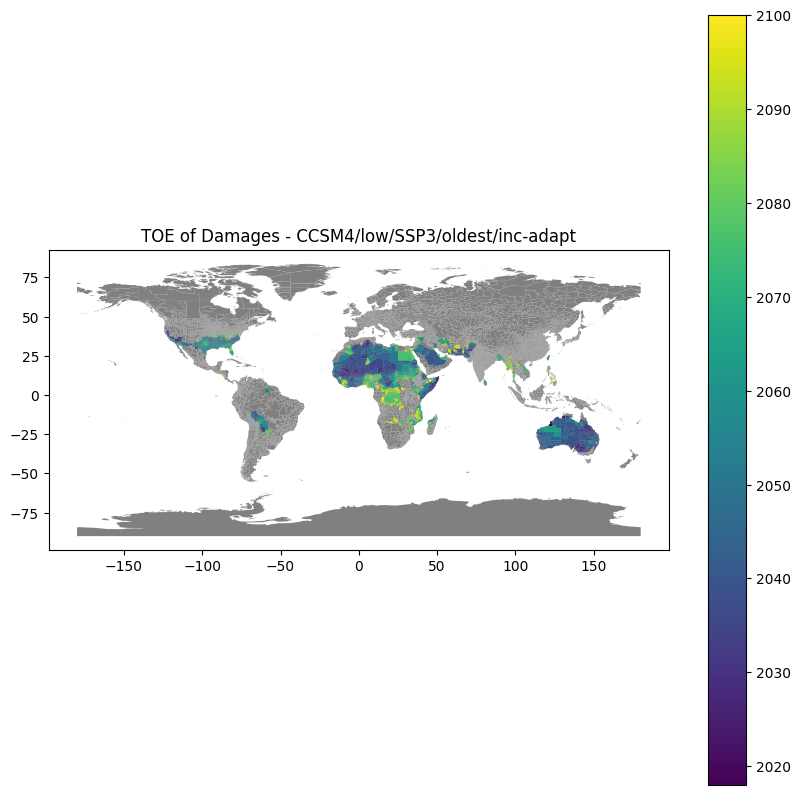

In [18]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
sf.plot(column="ISO",ax=ax,legend=False, color='grey')
sf.plot(column="TOE_damages",ax=ax,legend=True)
plt.title('TOE of Damages - CCSM4/low/SSP3/oldest/inc-adapt')



/tmp/ipykernel_50829/1331200644.py:2: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  sf.plot(column="ISO",ax=ax,legend=False, color='grey')


Text(0.5, 1.0, 'TOE of Benefits - CCSM4/low/SSP3/oldest/inc-adapt')

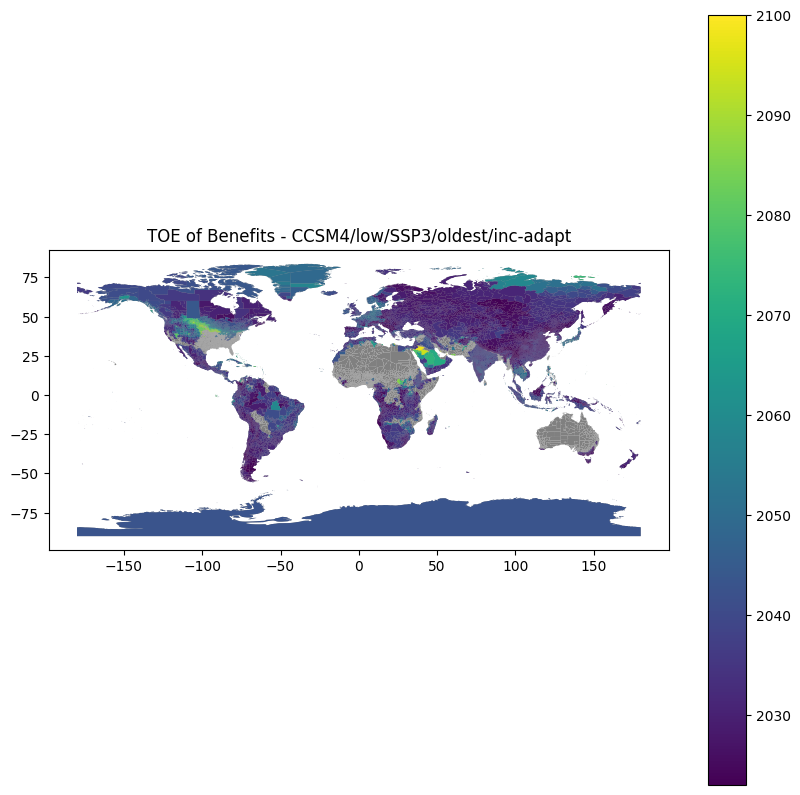

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
sf.plot(column="ISO",ax=ax,legend=False, color='grey')
sf.plot(column="TOE_benefits",ax=ax,legend=True)
plt.title('TOE of Benefits - CCSM4/low/SSP3/oldest/inc-adapt')



/tmp/ipykernel_50829/2027091918.py:3: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  sf.plot(column="ISO",ax=ax,legend=False, color='grey')


Text(0.5, 1.0, 'TOE of Damages - CCSM4/low/SSP3/oldest/no-adapt')

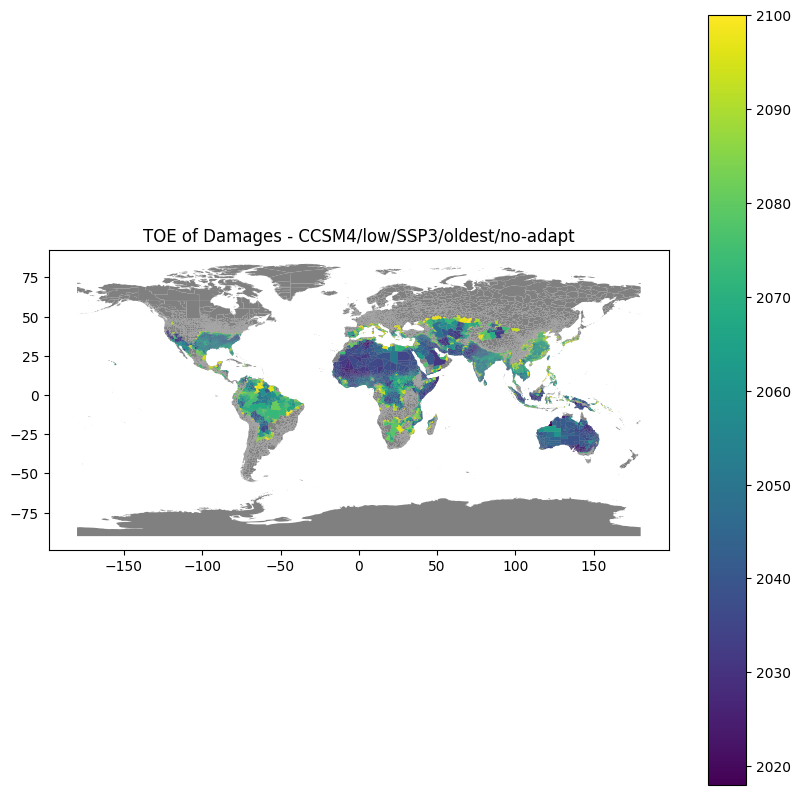

In [20]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
sf.plot(column="ISO",ax=ax,legend=False, color='grey')
sf.plot(column="TOE_damages_1",ax=ax,legend=True)
plt.title('TOE of Damages - CCSM4/low/SSP3/oldest/no-adapt')




/tmp/ipykernel_50829/2742766198.py:2: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  sf.plot(column="ISO",ax=ax,legend=False, color='grey')


Text(0.5, 1.0, 'TOE of Benefits - CCSM4/low/SSP3/oldest/no-adapt')

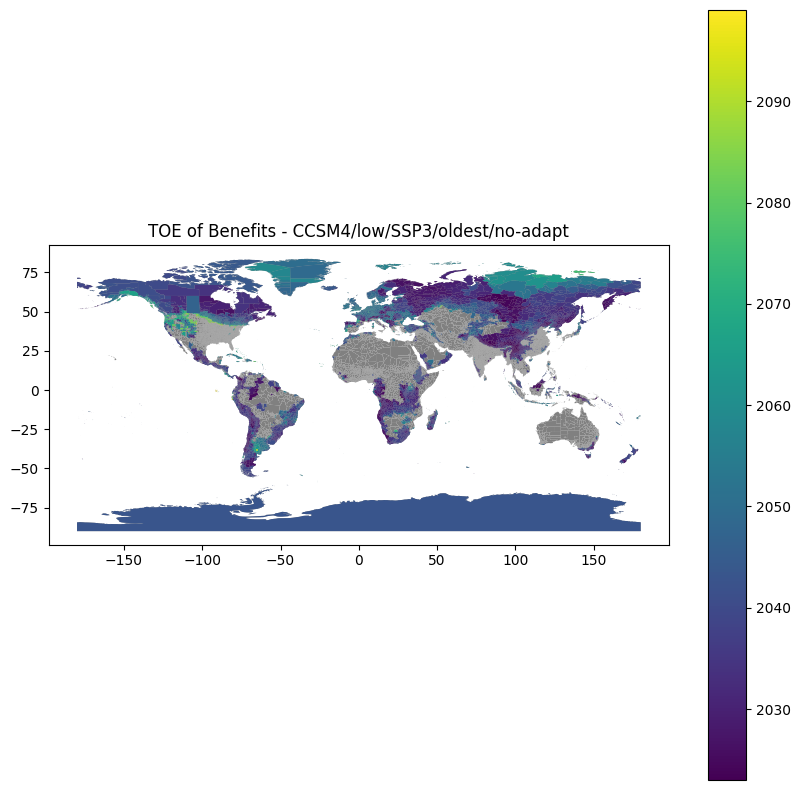

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
sf.plot(column="ISO",ax=ax,legend=False, color='grey')
sf.plot(column="TOE_benefits_1",ax=ax,legend=True)
plt.title('TOE of Benefits - CCSM4/low/SSP3/oldest/no-adapt')




In [22]:
econ = "/projects/kopp/dtb96/branches/Mortality_Project/data/2_projection/2_econ_vars/SSP3.nc4"
econ_vars = nc.Dataset(econ)
econ_vars
#plus_65 = econ_vars.variables['pop65plus'][:]


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): model(2), region(24378), year(91)
    variables(dimensions): <class 'str'> ssp(), <class 'str'> model(model), <class 'str'> region(region), int64 year(year), float64 pop(model, region, year), float64 pop0to4(model, region, year), float64 pop5to64(model, region, year), float64 pop65plus(model, region, year), float64 gdppc(model, region, year), float64 gdp(model, region, year)
    groups: 